<br>

# <center> Sudoku Solving using Computer Vision

<br>

## <center> Part 02 : Sudoku Image Processing

## <center> In this section, the sudoku image will be processed, and the designed CNN will predict each of the puzzle's digits, generating a 2D array of predicted digits.

<br>

---

<br>


# List of Contents

* [1. Initialization](#1-initialization)
* [2. Loading Pretrained Digit Classifier](#2-loading-pretrained-digit-classifier)
* [3. Reading The Sudoku Puzzle](#3-reading-the-sudoku-puzzle)
* [4. Image Processing Unit](#4-image-processing-unit)
* [5. Digit Classification Unit](#5-digit-classification-unit)
* [6. Sudoku Solving Unit](#6-sudoku-solving-unit)

<br>

---

<br>


<br>
<br>

<a name='1-initialization'></a>

# 1. Initialization

<br>

## 1.1. Colab Configuration

### 1.1.1. Mount Google Drive

In [1]:
'''
    This is required if the code runs in Google Colab.
    - this code will mount Google Drive for Colab.
    - the code needs to run only once.
'''

# # uncomment the below code, run and then comment again.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

### 1.1.2. Defining Root Directory

In [2]:
# -----------------------------------------------
#   Check the code is running on Colab or not   |
# -----------------------------------------------
import sys
is_running_on_colab = 'google.colab' in sys.modules


# -----------------------------------------------
#               Root Directory                  |
# -----------------------------------------------
# this directory will be used as Root Directory to read/write any file
if is_running_on_colab:
    # for google-colab
    rootDir = '/content/drive/MyDrive/_ML/Sudoku/'
else:
    # for application
    rootDir = './mlData/'
    

<br>

## 1.2. Import Libraries

In [3]:
# importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os, random
import cv2

In [5]:
import json

<br>

<a name='2-loading-pretrained-digit-classifier'></a>

# 2. Loading Pretrained Digit Classifier

In [6]:
# importing the required libraries
from keras.models import load_model

# defining the name of the model
modelName = 'DigitClassifier.h5'

# creating the path
path = rootDir + '03. Generated Data/' + modelName

# loading saved models
model = load_model( path )

<br>

<a name='3-reading-the-sudoku-puzzle'></a>

# 3. Reading The Sudoku Puzzle

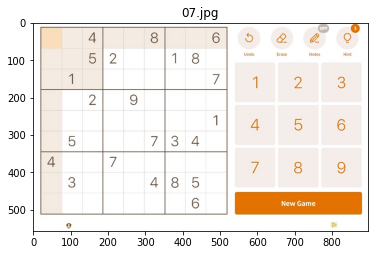

In [7]:
# defining the folder path of the sudoku puzzle images
folder = rootDir + "/02. Dataset/Evaluation"

# randomly select an image from the folder
# imgName = random.choice( os.listdir(folder) )

# select a specific image
imgName = '07.jpg'

# defining image path
image_path = folder + '/' + imgName

# reading the Sudoku Puzzle
sudoku_raw = cv2.imread(image_path)

plt.title(imgName)
plt.imshow(sudoku_raw)
plt.show() 

<br>

<a name='4-image-processing-unit'></a>

# 4. Image Processing Unit

<br>

## 4.1. Resizing the Image

In [8]:
# preprocessing image to be read
sudoku = cv2.resize(sudoku_raw, (450,450))

<br>

## 4.2. Detecting the Contours of the Image

> Calculating Threshold Image

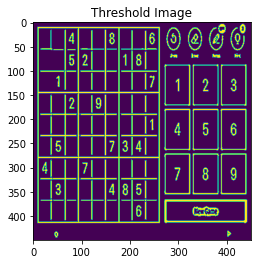

In [9]:
# function to greyscale, blur and change the receptive threshold of image
def get_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = get_threshold(sudoku)

# let's look at what we have got
plt.title('Threshold Image')
plt.imshow(threshold)
plt.show()

<br>

> Detect the biggest contour of the image.

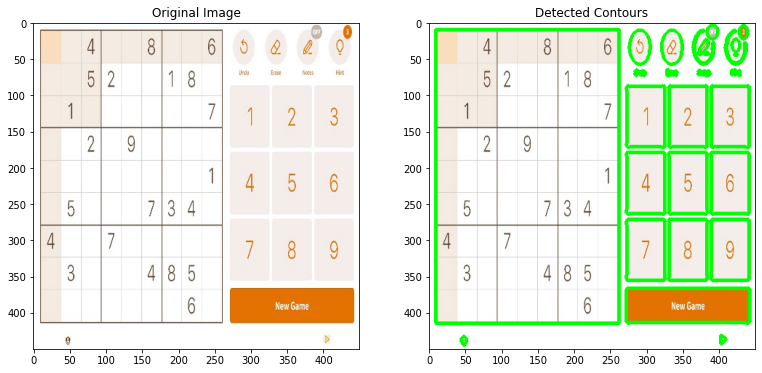

In [10]:
# Finding the outline of the sudoku puzzle in the image
contour, hierarchy = cv2.findContours(
                            threshold,
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE
                        )

contour_all = sudoku.copy()

cv2.drawContours(contour_all, contour, -1, (0,255,0), 3)


#let's see what we got
plt.figure(figsize=(13,6))

plt.subplot(1, 2, 1)
plt.imshow(sudoku)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(contour_all)
plt.title('Detected Contours')

plt.show()

<br>

## 4.3. Reshaping the outline to get the cropped and well-aligned Sudoku

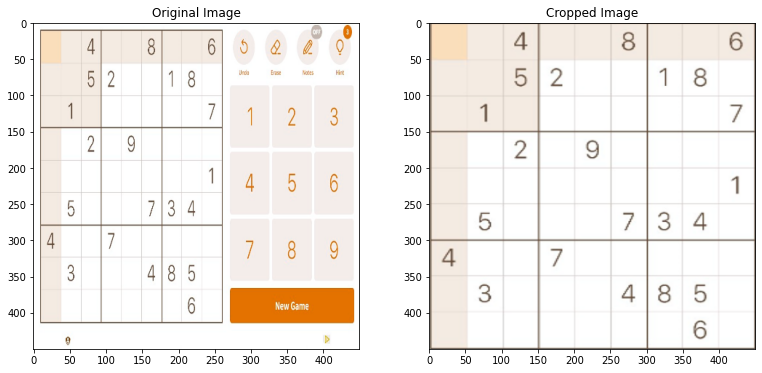

In [11]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2), dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new


black_img = np.zeros((450,450,3), np.uint8)
sudoku_copy = sudoku.copy()

biggest, maxArea = main_outline(contour)

if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(sudoku_copy,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    croppped_sudoku = cv2.warpPerspective(sudoku,matrix,(450,450))
else:
    raise TypeError('This puzzle is not possible to solve.')    

# displaying the images
plt.figure(figsize=(13,6))

plt.subplot(1, 2, 1)
plt.imshow(sudoku)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(croppped_sudoku)
plt.title('Cropped Image')

plt.show()

<br>

## 4.4. Splitting the Cells

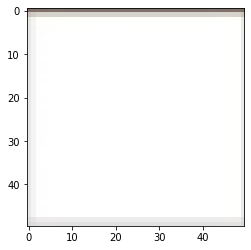

In [12]:
def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


sudoku_cell = splitcells(croppped_sudoku)

#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

> Croppping the Boundary

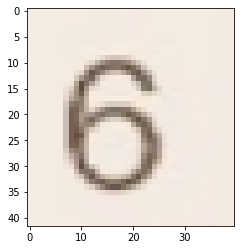

In [13]:
from PIL import Image 

# The sudoku_cell's output includes the boundaries this could lead to misclassifications by the model 
# I am cropping the cells to avoid that
# sneeking in a bit of PIL lib as cv2 was giving some weird error that i couldn't ward off

def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped = CropCell(sudoku_cell)

#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[8])
plt.show()

<br>

<a name='5-digit-classification-unit'></a>

# 5. Digit Classification Unit

In [14]:
def predict_cells(cells, model):

    result = []
    for cell in cells:
        img = np.asarray(cell)
        
        # preprocess the image as it was in the model 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)

        # getting predictions and setting the values if probabilities are above 65% 
        predictions = model.predict(img, verbose=0)
        probabilityValue = np.amax(predictions)
        classIndex = int( np.argmax(predictions, axis=1) )
        
        if probabilityValue > 0.65:
            result.append(classIndex)
        else:
            result.append(0)

    return result

grid = predict_cells(sudoku_cell_croped, model)

<br>

## 5.1 Reshaping the array into a 9 x 9 matrix

In [15]:
# converting to numpy array
puzzle = np.array(grid)

# Reshaping the grid to a 9x9 matrix
puzzle = np.reshape(puzzle, (9,9))

<br>

> Unsolved Sudoku

In [16]:
print('---------------------')
print(' Puzzle ')
print('--------------------- \n')

print(puzzle)

---------------------
 Puzzle 
--------------------- 

[[0 0 4 0 0 8 0 0 6]
 [0 0 5 2 0 0 1 8 0]
 [0 1 0 0 0 0 0 0 7]
 [0 0 2 0 9 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 5 0 0 0 7 3 4 0]
 [4 0 0 7 0 0 0 0 0]
 [0 3 0 0 0 4 8 5 0]
 [0 0 0 0 0 0 0 6 0]]


<br>

<a name='6-sudoku-solving-unit'></a>

# 6. Sudoku Solving Unit

> Install Colab Turtle Plus if required

In [17]:
# "ColabTurtlePlus" is for Colab Usecase, otherwise use "Turtle"
!pip install ColabTurtlePlus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<br>

> Importing the Local Module

In [18]:
# defining the module path
module_path = rootDir + '01. CodeBase/01. Sudoku Solver/pkg'

# adding the module path to the sys.path
import sys
sys.path.append(module_path)

In [19]:
# importing the Module
import PuzzleSolver as solver
import DisplayTurtle as disp

Put clearscreen() as the first line in a cell (after the import command) to re-run turtle commands in the cell


<br>

> Sudoku Image

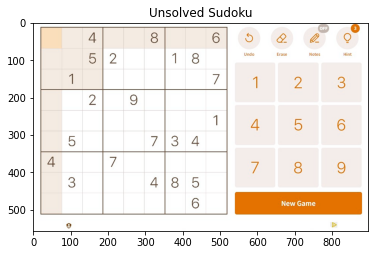

In [20]:
plt.figure()
plt.imshow(sudoku_raw)
plt.title('Unsolved Sudoku')

plt.show() 

<br>

> Unsolved Sudoku

In [21]:
print('---------------------')
print(' Puzzle ')
print('--------------------- \n')

disp.print_sudoku(puzzle)

---------------------
 Puzzle 
--------------------- 



<br>

> Solved Sudoku

In [22]:
print('---------------------')
print(' Solution ')
print('--------------------- \n')

solver.solve_sudoku(puzzle)

---------------------
 Solution 
--------------------- 

